# PART 4   : Predir la réponse d une question de type OUI/NON

Pour cette partie, on va utiliser la question numéro 5 :
    - Avez-vous pour vos déplacements quotidiens la possibilité de recourir 
    à des solutions de mobilité alternatives à la voiture individuelle comme les transports en commun,
    le covoiturage, l auto-partage, le transport à la demande, le vélo, etc. ?

On constaté qu il y a un nombre considerable de participants qui n ont pas donné leur reponse pour cette question.
Pour cela, on va essayer de predir leurs reponses en utilisant les autres réponses qu ils ont fourni. 

Pour cette fin, nous allons  utilisé la colonne title et les reponses aux questionx 6,7 et 8 puisque ils sont 
en relation avec la question 5.

    Question 6 :  Si oui, que faudrait-il faire pour vous convaincre ou vous aider à utiliser ces solutions alternatives ?

    Question 7 :  Si non, quelles sont les solutions de mobilité alternatives que vous souhaiteriez pouvoir utiliser ?
    
    Question 8 :  Et qui doit selon vous se charger de vous proposer ce type de solutions alternatives ?

# Les librairies nécessaires 

In [18]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)


##Librairies for preprocessing and evaluation of performance

import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

##Librairies for RNN
from keras import layers, models, optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input, concatenate, Dropout, GRU
from tensorflow.python.keras.optimizers import  RMSprop
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.python.keras.optimizers import Adam
from sklearn import metrics
from keras.callbacks import EarlyStopping

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ahlem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ahlem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
environment_pd = pd.read_csv('LA_TRANSITION_ECOLOGIQUE.csv', low_memory=False)  ##Charger la base de données
environment_pd.head()

,id,reference,title,createdAt,publishedAt,updatedAt,trashed,trashedStatus,authorId,authorType,...,"QUXVlc3Rpb246MTUw - Qu'est-ce qui pourrait vous inciter à changer vos comportements comme par exemple mieux entretenir et régler votre chauffage, modifier votre manière de conduire ou renoncer à prendre votre véhicule pour de très petites distances ?",QUXVlc3Rpb246MTUx - Quelles seraient pour vous les solutions les plus simples et les plus supportables sur un plan financier pour vous inciter à changer vos comportements ?,"QUXVlc3Rpb246MTUy - Par rapport à votre mode de chauffage actuel, pensez-vous qu'il existe des solutions alternatives plus écologiques ?","QUXVlc3Rpb246MTUz - Si oui, que faudrait-il faire pour vous convaincre ou vous aider à changer de mode de chauffage ?","QUXVlc3Rpb246MTU0 - Avez-vous pour vos déplacements quotidiens la possibilité de recourir à des solutions de mobilité alternatives à la voiture individuelle comme les transports en commun, le covoiturage, l'auto-partage, le transport à la demande, le vélo, etc. ?","QUXVlc3Rpb246MTU1 - Si oui, que faudrait-il faire pour vous convaincre ou vous aider à utiliser ces solutions alternatives ?","QUXVlc3Rpb246MjA3 - Si non, quelles sont les solutions de mobilité alternatives que vous souhaiteriez pouvoir utiliser ?",QUXVlc3Rpb246MTU3 - Et qui doit selon vous se charger de vous proposer ce type de solutions alternatives ?,QUXVlc3Rpb246MTU4 - Que pourrait faire la France pour faire partager ses choix en matière d'environnement au niveau européen et international ?,QUXVlc3Rpb246MTU5 - Y a-t-il d'autres points sur la transition écologique sur lesquels vous souhaiteriez vous exprimer ?
0,UHJvcG9zYWw6ZmZlN2MwNzktMWUyMC0xMWU5LTk0ZDItZm...,2-4,transition écologique,2019-01-22 09:37:49,2019-01-22 09:37:49,NaN,False,NaN,VXNlcjoxMTQwMTc0YS0xZTFmLTExZTktOTRkMi1mYTE2M2...,Citoyen / Citoyenne,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Enseignement du tri sélectif à l'école,Multiplier les centrales géothermiques
1,UHJvcG9zYWw6M2RmZmUxZjMtMWUyMS0xMWU5LTk0ZDItZm...,2-5,La surpopulation,2019-01-22 09:39:33,2019-01-22 09:39:33,NaN,False,NaN,VXNlcjpjOWYxZWQ1NS0xYzEwLTExZTktOTRkMi1mYTE2M2...,Citoyen / Citoyenne,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mettre en oeuvre au niveau national ses engage...,Les problèmes auxquels se trouve confronté l’e...
2,UHJvcG9zYWw6NDg1YWUxYjItMWUyMS0xMWU5LTk0ZDItZm...,2-6,climat,2019-01-22 09:39:50,2019-01-22 09:39:50,NaN,False,NaN,VXNlcjozZjlhNzAwOS0xYTc2LTExZTktOTRkMi1mYTE2M2...,Citoyen / Citoyenne,...,"développer les transports en commun ,",NaN,Non,NaN,Oui,NaN,Les transports en commun|L'auto partage|Le tra...,NaN,NaN,NaN
3,UHJvcG9zYWw6NTk2Nzk5MmItMWUyMS0xMWU5LTk0ZDItZm...,2-7,POLLUTION AIR EAU,2019-01-22 09:40:19,2019-01-22 09:40:19,NaN,False,NaN,VXNlcjozOWQwNzJjNC0xZDEwLTExZTktOTRkMi1mYTE2M2...,Citoyen / Citoyenne,...,NaN,Plus de transports publics dans les petites co...,Non,NaN,Non,Le co-voiturage ne correspond pas toujours aux...,Les transports en commun,L'Etat,Elle n'a aucun pouvoir. Impossible de contrain...,NaN
4,UHJvcG9zYWw6ODU5NWMyOTYtMWUyMS0xMWU5LTk0ZDItZm...,2-8,Economie vs Ecologie,2019-01-22 09:41:33,2019-01-22 09:41:33,NaN,False,NaN,VXNlcjo3M2YxN2NlZS0xZDRiLTExZTktOTRkMi1mYTE2M2...,Citoyen / Citoyenne,...,"Aménagement de piste cyclable, développement d...","Détaxer le mode de chauffage écologique, une a...",Oui,une aide significative pour de l'éolien ou du ...,Non,Une piste cyclable pour éviter de risquer ma v...,Les transports en commun|Le covoiturage|Le vélo,"La commune, le département, la région",Demander à Nicolas Hulot,Une vrai politique écologique et non économique


# Defining des nouvelles entêtes pour une manipulation facile

In [5]:
environment_pd.columns= ['id', 'reference', 'title', 'createdAt', 'publishedAt', 'updatedAt','trashed', 'trashedStatus', 'authorId', 'authorType', 'authorZipCode', 'q1', 'q2', 'q1','q4','YES/NO Question','q6','q7','q8','q9','q10','q11','q12','q13','q14','q15','q16']
reduced_dataset_df = environment_pd[[ 'title',  'YES/NO Question','q6','q7','q8']]
reduced_dataset_df.head()

,title,YES/NO Question,q6,q7,q8
0,transition écologique,NaN,NaN,NaN,NaN
1,La surpopulation,NaN,NaN,NaN,NaN
2,climat,Non,NaN,"développer les transports en commun ,",NaN
3,POLLUTION AIR EAU,Non,NaN,NaN,Plus de transports publics dans les petites co...
4,Economie vs Ecologie,Oui,"En consommant autrement, en vivant autrement.","Aménagement de piste cyclable, développement d...","Détaxer le mode de chauffage écologique, une a..."


### Extraire les reponses null pour les predirs après.

In [115]:
nanResponse= reduced_dataset_df[reduced_dataset_df['YES/NO Question'].isnull()]  ##extraire les réponses null
nanResponse= nanResponse.dropna(axis=0, subset=['q6','q7','q8'])        ###Eliminer les colonnes où il n ya aucune 
                                                                        ##réponse fournit pour les autres questions
nanResponse.head()

,title,YES/NO Question,q6,q7,q8
85,Retour au raisonnable,NaN,Mon jardin est cultivé en permaculture. pesti...,Avoir une solution de rechange pratique. ex tr...,"Plus d'aides pour acquisition / location vélo,..."
339,Transition écologique une génération pou y a...,NaN,J 'aimerai bien mais ma ville Marseille n' pas...,\tTransport public inclure dans nos impôts lo...,que les grands corps d'état régions et départe...
693,arretez les doctrinnaires,NaN,je le fait deja,je le fait deja,"devellopper les parkings de proximite, surtout..."
1695,Ecologie,NaN,"Tri sélectif, transport en commun, limiter le ...",Une meilleur approche du tri sélectif et un dé...,Le système de consigne ne pénalise personne et...
1802,Préparer les générations futures au changement...,NaN,J'ai supprimé certains aliments de mon panier ...,Des avantages fiscaux,Généraliser le télétravail lorsque cela est po...


# Preparation de la base de données pour le model

In [7]:
##Eliminer les reponses nulles
reduced_dataset_df['YES/NO Question'] = reduced_dataset_df['YES/NO Question'].replace('nan', np.nan)
data_df=reduced_dataset_df.dropna(axis=0, subset=['YES/NO Question'])
data_df.head()

,title,YES/NO Question,q6,q7,q8
2,climat,Non,NaN,"développer les transports en commun ,",NaN
3,POLLUTION AIR EAU,Non,NaN,NaN,Plus de transports publics dans les petites co...
4,Economie vs Ecologie,Oui,"En consommant autrement, en vivant autrement.","Aménagement de piste cyclable, développement d...","Détaxer le mode de chauffage écologique, une a..."
5,égalité territoriale de traitement,Oui,en consommant moins de produits manufacturé à ...,déjà fait,NaN
6,Nous sommes les gardiens de la terre et des pa...,Oui,"Plus aucun pesticide , marche à pied le plus s...","Transports en commun , reconstruction de ligne...",Baisse des impôts avec obligation de réaliser ...


In [8]:
## Remplacer les réponses OUI par 1 et NON par 0
data_df['YES/NO Question'] = data_df['YES/NO Question'].replace('Non', '0')
data_df['YES/NO Question'] = data_df['YES/NO Question'].replace('Oui', '1')


 Remplacer les réponses Null dans les autres questions par 'Pas de réponse' car il y des questions qui sont reliés à 
 une reponse de type Oui et d'autres qui sont reliés à une réponse de type Non. Donc on aura des valeurs null mais qui portent une information utile.

In [9]:
data_df['q6'] = data_df['q6'].replace(np.nan, 'Pas de reponse')
data_df['q7'] = data_df['q7'].replace(np.nan, 'Pas de reponse')
data_df['q8'] = data_df['q8'].replace(np.nan, 'Pas de reponse')
data_df.head()

,title,YES/NO Question,q6,q7,q8
2,climat,0,Pas de reponse,"développer les transports en commun ,",Pas de reponse
3,POLLUTION AIR EAU,0,Pas de reponse,Pas de reponse,Plus de transports publics dans les petites co...
4,Economie vs Ecologie,1,"En consommant autrement, en vivant autrement.","Aménagement de piste cyclable, développement d...","Détaxer le mode de chauffage écologique, une a..."
5,égalité territoriale de traitement,1,en consommant moins de produits manufacturé à ...,déjà fait,Pas de reponse
6,Nous sommes les gardiens de la terre et des pa...,1,"Plus aucun pesticide , marche à pied le plus s...","Transports en commun , reconstruction de ligne...",Baisse des impôts avec obligation de réaliser ...


Deviser la dataset en features X et label Y
X : contient toutes les réponses regroupées en une seule colonne

In [116]:
concatenated_train = data_df['title'].map(str) +' ' +data_df['q6'].map(str) + ' '+data_df['q7'].map(str) +' '+ data_df['q8'].map(str)
concatenated_nanResponse = nanResponse['title'].map(str) +' ' +nanResponse['q6'].map(str) + ' '+nanResponse['q7'].map(str) +' '+ nanResponse['q8'].map(str)

X = pd.DataFrame(concatenated_train, columns=['response'])
Y=data_df[['YES/NO Question']]

X_nanResponse =  pd.DataFrame(concatenated_nanResponse, columns=['response'])


In [11]:
Y['YES/NO Question'].value_counts()  ##Evaluer le nombre des reponses OUI et le nombre des reponses NON

1    74801
0     4450
Name: YES/NO Question, dtype: int64

On voit bien que la dataset est non équilibrée. Le nombre des réponses 'OUI' sont plus importants que les réponses NON.
On essayera donc d'appliquer des poids pour pénaliser les erreurs dans le calcul du loss.

In [12]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(Y['YES/NO Question']),Y['YES/NO Question'])
print(class_weights)

[8.90460674 0.52974559]


# Clean the data

### 2.1 ['Tokenize', 'the', 'data']

In [13]:
def clean(X): #X column data
    pd_list = list(X)
    pd_list = [it.lower() for it in pd_list] # to lowercase
    pd_list = [re.sub(r'ô','o',it) for it in pd_list] 
    pd_list = [re.sub(r'([^a-zéèûôàêô])',' ',it) for it in pd_list]

  
    return pd_list

In [14]:
def tokenization(X_list):
    tokenized_df = [word_tokenize(it) for it in X_list]
   
    return tokenized_df

### 2.2  Stopwords removal

In [15]:

#We added this list to give more sens to our results.
other_stopwords = ['les','a','afin','alors', 'tout', 'tous', 'prends',
                   'tre', 'si','doit','avoir','comme','leurs','faire','ils',
                   'peut','bien','aussi','cela','gens', 'sans', 
                   'car', 'très', 'fait', '\'', 'qu\'', 'd\'', 'l\'', '"', 'être', 'mai']

stopWords = stopwords.words('french')
stopWords.extend(other_stopwords)
stopWords = set(stopWords)

def remove_stopwords(X_list):
    filtered_list =[]
    for it in X_list:
        
        temp = []
        for word in it:
            if(word not in stopWords):
                temp.append(word)
        filtered_list.append(temp)
        temp=[]
     
    return filtered_list

In [16]:
### return column data cleaned and without stopwords
def clean_remove_stopwords(column_data):
    non_stopwords_data = remove_stopwords(tokenization(clean(column_data)))
    non_tokenized = []
    for l in non_stopwords_data:
        non_tokenized.append(' '.join(l))
  
    return non_tokenized


In [117]:
data_clean_df = pd.DataFrame()
X_nanResponse_clean_df=pd.DataFrame()

data_clean_df['response'] =clean_remove_stopwords(X['response'])   ##Eliminer stop words dans les données
X_nanResponse_clean_df['response'] =clean_remove_stopwords(X_nanResponse['response'])  ### Eliminer les stops words dans les
                                                                                       ### données des réponses non fournit

In [20]:
data_clean_df.head()

,response
0,climat reponse développer transports commun re...
1,pollution air eau reponse reponse plus transpo...
2,economie vs ecologie consommant autrement viva...
3,égalité territoriale traitement consommant moi...
4,gardiens terre passeurs enfants plus aucun pes...


### 2.3 Tokenization

In [21]:
num_words = 20000
tokenizer = Tokenizer(num_words=num_words)

tokenizer.fit_on_texts(data_clean_df['response'])
x_tokens = tokenizer.texts_to_sequences(data_clean_df['response'])

In [22]:
## Chercher la valeur optimale pour la tokenization 

In [23]:
num_tokens = [len(tokens) for tokens in x_tokens]
num_tokens = np.array(num_tokens)
print('The average number of tokens in a sequence is {}'.format(np.mean(num_tokens)))
print('The maximum number of tokens in a sequence is {}'.format(np.max(num_tokens)))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
print('The chosen max tokens is {}'.format(max_tokens))
print('The pourcentage of entries that don''t reach the max tokens {}'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

The average number of tokens in a sequence is 41.42909237738325
The maximum number of tokens in a sequence is 5317
The chosen max tokens is 131
The pourcentage of entries that dont reach the max tokens 0.9737290381193928


In [118]:
pad = 'pre'

X_pad = pad_sequences(x_tokens, maxlen=max_tokens,padding=pad, truncating=pad) ##Convertir les réponses en des séquences de meme taille
X_nanResponse_pad = pad_sequences(x_tokens,maxlen=max_tokens,padding=pad, truncating=pad)

print('The new shape of our train data after padding is {}'.format(X_pad.shape))

The new shape of our train data after padding is (79251, 131)


### 2.4 Definir le training set et le test set

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X_pad,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(71325, 131) (71325, 1)
(7926, 131) (7926, 1)


# Built The model

Nous sommes maintenant prêts à créer le réseau de neurones récurrents (RNN). Nous allons utiliser l'API Keras.


La première couche du RNN est une couche dite d’incorporation qui convertit chaque jeton entier en un vecteur de valeurs.
Cela est nécessaire car les entiers-jetons peuvent prendre des valeurs comprises entre 0 et 20000 pour un vocabulaire de 
20000 mots. Le RNN ne peut pas travailler sur des valeurs dans une plage si large. La couche d’incorporation fait partie 
du RNN et apprendra à mapper des mots ayant une signification sémantique similaire à des vecteurs d’incorporation similaires, 
comme nous le verrons plus loin.

Nous définissons d’abord la taille du vecteur d’incorporation pour chaque jeton entier. Dans ce cas, nous avons défini la 
valeur sur 300, de sorte que chaque entier-jeton soit converti en un vecteur de longueur 300.


In [29]:
embedding_size=300
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 1000 # max number of words in a question to use

model = Sequential()
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='layer_embedding'))
model.add(GRU(units=16, return_sequences=True))  ## GRU model avec 16 outputs
model.add(GRU(units=8, return_sequences=True))   ## GRU model avec 8 outputs
model.add(GRU(units=4))                          ## GRU model avec 4 outputs
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(lr=1e-3)

In [33]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 131, 300)          6000000   
_________________________________________________________________
gru_4 (GRU)                  (None, 131, 16)           15216     
_________________________________________________________________
gru_5 (GRU)                  (None, 131, 8)            600       
_________________________________________________________________
gru_6 (GRU)                  (None, 4)                 156       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 6,015,977
Trainable params: 6,015,977
Non-trainable params: 0
_________________________________________________________________


In [34]:
%%time
history=model.fit(X_train, Y_train,           ##Compiler le model avec 2 epochs et batch size de 64.
                  validation_split=0.05, epochs=2, 
                  batch_size=64, 
                  class_weight=class_weights, 
                  callbacks=[EarlyStopping(monitor='val_loss', 
                                           patience=3, min_delta=0.0001)])

Train on 67758 samples, validate on 3567 samples
Epoch 1/2
67758/67758 [==============================] - 296s 4ms/step - loss: 0.1582 - acc: 0.9554 - val_loss: 0.1224 - val_acc: 0.9622
Epoch 2/2
67758/67758 [==============================] - 282s 4ms/step - loss: 0.0886 - acc: 0.9716 - val_loss: 0.1169 - val_acc: 0.9602
Wall time: 9min 41s


In [35]:
%%time
result = model.evaluate(X_test, Y_test)   ###Evaluer le model

7926/7926 [==============================] - 9s 1ms/step
Wall time: 8.51 s


# Test the perfermance 

In [36]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(result[0],result[1]))  ##Calcul de l'accuracy

Test set
  Loss: 0.110
  Accuracy: 0.962


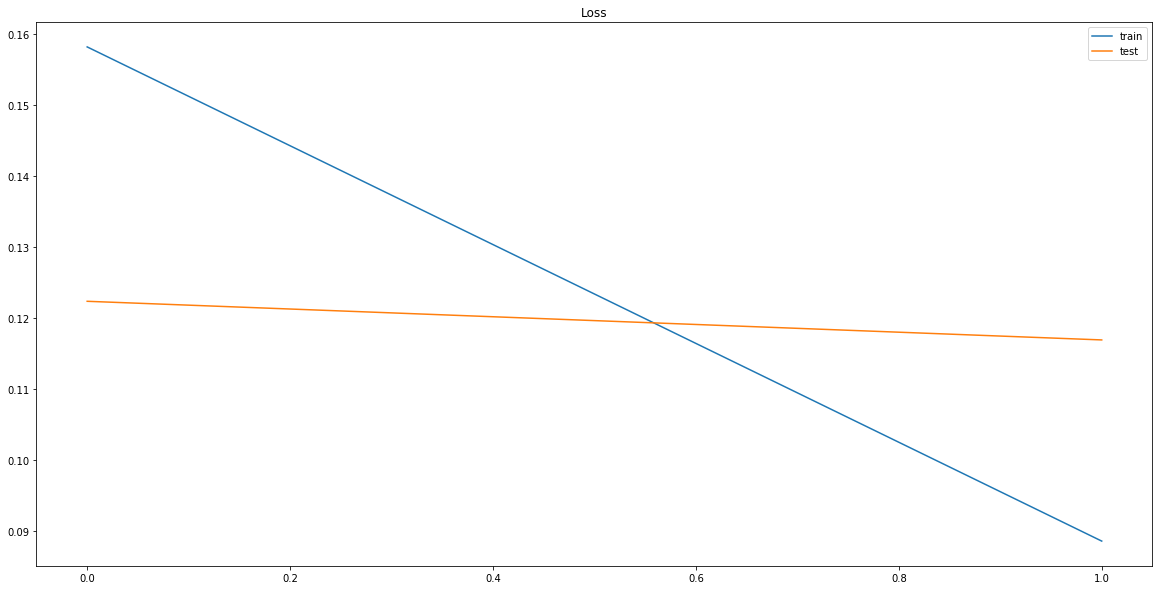

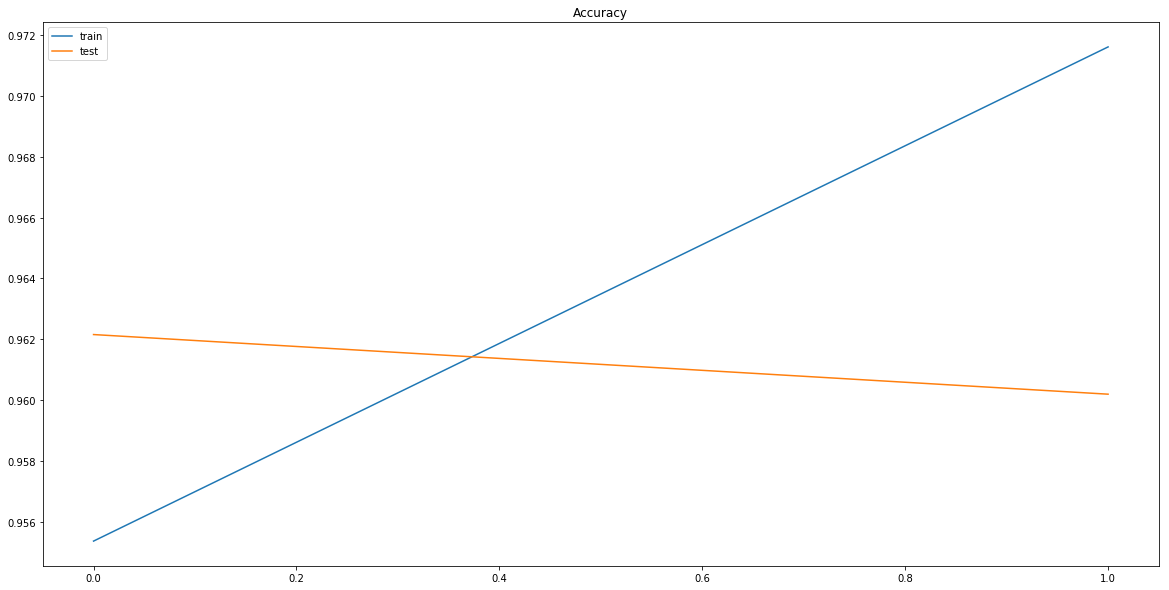

In [37]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

THRESHHOLD = 0.5
predicted = pd.DataFrame(model.predict(X_test))
predicted[predicted<THRESHHOLD] = 0
predicted[predicted>=THRESHHOLD] = 1

In [38]:
predicted_values = predicted[0].values
predicted_values = [int(i) for i in predicted_values]
true_values = Y_test.values
true_values = [int(i) for i in true_values]

labels=[0, 1]
cm = confusion_matrix(true_values, predicted_values, labels)

In [39]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    

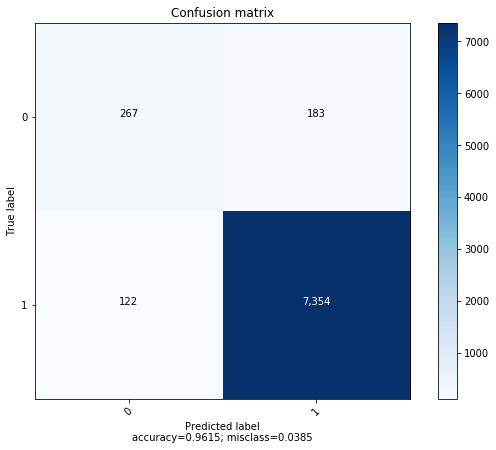

The recall equals to 0.983681112894596


In [40]:
plot_confusion_matrix(cm,labels, normalize=False)  ## Dessiner la matrice de confusion
recall = cm[1, 1] / (cm[1,1] + cm[1,0])
print('The recall equals to {}'.format(recall))

# Predir les réponses Nan

In [119]:
Y_pred= model.predict(X_nanResponse_pad)  ## Predir les réponses non fournit par les utilisateurs

In [120]:
## Arrondir les valeurs 
y=pd.DataFrame(np.round(Y_pred)).iloc[:]
y.head()

,0
0,0.0
1,0.0
2,1.0
3,1.0
4,1.0


In [121]:
##Remplacer les valeurs 0 par Non et 1 par Oui
y=y.replace(0.0,'Non')
y=y.replace(1.0,'Oui')
y.head()

,0
0,Non
1,Non
2,Oui
3,Oui
4,Oui


In [122]:
nanResponse['Response']= y

In [127]:
### Redefinir les entêtes
nanResponse.columns=['title','reponse Nan','Si oui, que faudrait-il faire pour vous convaincre ou vous aider à utiliser ces solutions alternatives ?'
                    ,'Si non, quelles sont les solutions de mobilité alternatives que vous souhaiteriez pouvoir utiliser ?'
                     ,'Et qui doit selon vous se charger de vous proposer ce type de solutions alternatives ?'
                    ,'Avez-vous pour vos déplacements quotidiens la possibilité de recourir  à des solutions de mobilité alternatives à la voiture individuelle comme les transports en commun,le covoiturage, l auto-partage, le transport à la demande, le vélo, etc. ?']

In [135]:
nanResponse.head()  ### La base de données finale

,title,reponse Nan,"Si oui, que faudrait-il faire pour vous convaincre ou vous aider à utiliser ces solutions alternatives ?","Si non, quelles sont les solutions de mobilité alternatives que vous souhaiteriez pouvoir utiliser ?",Et qui doit selon vous se charger de vous proposer ce type de solutions alternatives ?,"Avez-vous pour vos déplacements quotidiens la possibilité de recourir à des solutions de mobilité alternatives à la voiture individuelle comme les transports en commun,le covoiturage, l auto-partage, le transport à la demande, le vélo, etc. ?"
85,Retour au raisonnable,NaN,Mon jardin est cultivé en permaculture. pesti...,Avoir une solution de rechange pratique. ex tr...,"Plus d'aides pour acquisition / location vélo,...",Non
339,Transition écologique une génération pou y a...,NaN,J 'aimerai bien mais ma ville Marseille n' pas...,\tTransport public inclure dans nos impôts lo...,que les grands corps d'état régions et départe...,Oui
693,arretez les doctrinnaires,NaN,je le fait deja,je le fait deja,"devellopper les parkings de proximite, surtout...",Oui
1695,Ecologie,NaN,"Tri sélectif, transport en commun, limiter le ...",Une meilleur approche du tri sélectif et un dé...,Le système de consigne ne pénalise personne et...,Oui
1802,Préparer les générations futures au changement...,NaN,J'ai supprimé certains aliments de mon panier ...,Des avantages fiscaux,Généraliser le télétravail lorsque cela est po...,Oui
